**1. Read and import data**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
dataset = pd.read_csv('./data/salary.csv', sep='|')

In [3]:
dataset.head(2)

,id,job_title,location,salary_currency,career_level,experience_level,education_level,employment_type,job_function,job_benefits,company_process_time,company_size,company_industry,job_description,salary
0,1,Facility Maintenance & Smart Warehouse Manager,Bandung,IDR,Manajer/Asisten Manajer,5 tahun,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",Penuh Waktu,"Manufaktur,Pemeliharaan",NaN,NaN,NaN,NaN,Deskripsi PekerjaanRequirements :D3/SI from re...,NaN
1,2,Procurement Department Head,Jakarta Raya,IDR,Manajer/Asisten Manajer,5 tahun,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",Penuh Waktu,"Manufaktur,Pembelian/Manajemen Material",NaN,25 days,51 - 200 pekerja,Manajemen/Konsulting HR,Job Role: 1. Responsible for material availabi...,NaN


**2. Cleaning the data**

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34746 entries, 0 to 34745
Data columns (total 15 columns):
id                      34746 non-null int64
job_title               34746 non-null object
location                34746 non-null object
salary_currency         34742 non-null object
career_level            34746 non-null object
experience_level        30205 non-null object
education_level         34746 non-null object
employment_type         33402 non-null object
job_function            34746 non-null object
job_benefits            27330 non-null object
company_process_time    24555 non-null object
company_size            29103 non-null object
company_industry        33132 non-null object
job_description         34745 non-null object
salary                  9352 non-null float64
dtypes: float64(1), int64(1), object(13)
memory usage: 4.0+ MB


In [5]:
# Check null values
dataset.isnull().sum()

id                          0
job_title                   0
location                    0
salary_currency             4
career_level                0
experience_level         4541
education_level             0
employment_type          1344
job_function                0
job_benefits             7416
company_process_time    10191
company_size             5643
company_industry         1614
job_description             1
salary                  25394
dtype: int64

In [6]:
# Remove Column 
dataset = dataset.drop(labels=["id", "salary_currency", "job_benefits", "job_function", "job_description",
"company_process_time", "company_size", "company_industry", "employment_type"], axis=1)

Cleaning Salary

In [7]:
# Mengisi data salary yang nan atau null dengan median
dataset['salary'].fillna(dataset.groupby(["experience_level"])['salary'].transform('median'), inplace=True)
dataset['salary'] = dataset['salary'].round(0)

Cleaning Experience Level

In [8]:
# Convert experience_level str => float
dataset["experience_level"] = dataset["experience_level"].str.replace("\D", "").fillna(0).astype('float')

# Mengisi data experience_level yang 0 dengan median
dataset['experience_level'].replace(to_replace=0, value=dataset.groupby(["salary"])['experience_level'].transform('median'), inplace=True)

Outlier

In [9]:
dataset.dropna(inplace=True)

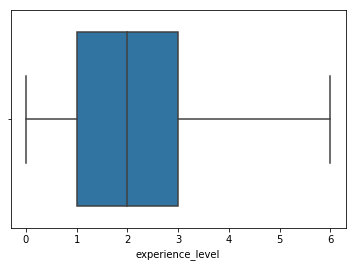

In [10]:
# Experience
per25Exp = dataset['experience_level'].quantile(0.25)
per75Exp = dataset['experience_level'].quantile(0.75)
iqrExp = per75Exp - per25Exp

lower_limit = per25Exp - 1.5 * iqrExp
upper_limit = per75Exp + 1.5 * iqrExp

dataset = dataset[~((dataset["experience_level"] < (lower_limit)) | (dataset["experience_level"] > (upper_limit)))]

sns.boxplot(dataset["experience_level"])
plt.show()

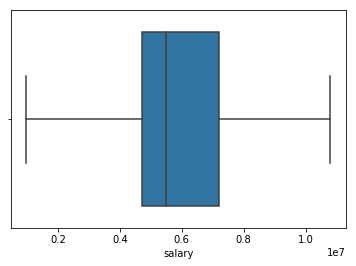

In [11]:
# Salary
per25Salary = dataset['salary'].quantile(0.25)
per75Salary = dataset['salary'].quantile(0.75)
iqrSalary = per75Salary - per25Salary

lower_limit = per25Salary - 1.5 * iqrSalary
upper_limit = per75Salary + 1.5 * iqrSalary

dataset = dataset[~((dataset["salary"] < (lower_limit)) | (dataset["salary"] > (upper_limit)))]

sns.boxplot(dataset["salary"])
plt.show()

Result Cleaning

In [12]:
dataset.shape

(28607, 6)

In [13]:
# Check null values
dataset.isnull().sum()

job_title           0
location            0
career_level        0
experience_level    0
education_level     0
salary              0
dtype: int64

In [14]:
dataset.reset_index(drop=True, inplace=True)
dataset.head(5)

,job_title,location,career_level,experience_level,education_level,salary
0,Facility Maintenance & Smart Warehouse Manager,Bandung,Manajer/Asisten Manajer,5.0,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",10500000.0
1,Procurement Department Head,Jakarta Raya,Manajer/Asisten Manajer,5.0,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",10500000.0
2,SALES ADMIN,Jakarta Barat,Supervisor/Koordinator,4.0,Sarjana (S1),8450000.0
3,City Operation Lead Shopee Express (Cirebon),Cirebon,Supervisor/Koordinator,5.0,"Sarjana (S1), Diploma Pascasarjana, Gelar Prof...",10500000.0
4,Japanese Interpreter,Bekasi,Pegawai (non-manajemen & non-supervisor),2.0,"Sertifikat Professional, D3 (Diploma), D4 (Dip...",5500000.0


In [15]:
dataset.describe()

,experience_level,salary
count,28607.000000,2.860700e+04
mean,2.141084,5.980619e+06
std,1.251596,1.923043e+06
min,0.000000,9.600000e+05
25%,1.000000,4.700000e+06
50%,2.000000,5.500000e+06
75%,3.000000,7.200000e+06
max,6.000000,1.080000e+07


**3. Discovering the data**

Kind of Experience Level

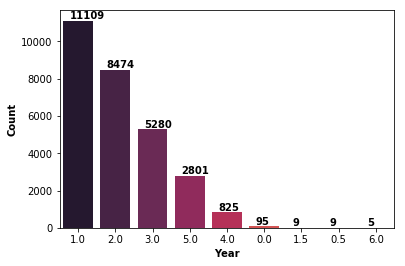

In [16]:
countEXP = sns.load_dataset("tips")
barExp = sns.countplot(data = countEXP, x = dataset["experience_level"], palette="rocket", order = dataset["experience_level"].value_counts().index)
plt.ylabel("Count", fontweight='bold')
plt.xlabel("Year", fontweight='bold')

for p, label in zip(barExp.patches, dataset["experience_level"].value_counts()):
    barExp.annotate(label, (p.get_x() + 1/6, p.get_height() + 100), fontweight='bold')
    
plt.show()

Average Salary based on Experience Level

In [17]:
dataset.groupby(by="experience_level")["salary"].mean().round(0).nlargest(10) 

experience_level
5.0    10019746.0
4.0     8198712.0
6.0     7890000.0
3.0     7027532.0
1.5     5516667.0
2.0     5514822.0
1.0     4679527.0
0.0     3352857.0
0.5     3097778.0
Name: salary, dtype: float64

**4. Predict the salary**

In [18]:
stats.pearsonr(x=dataset["experience_level"], y=dataset["salary"])

(0.8447319414457128, 0.0)

In [19]:
xYear = dataset.loc[:, ["experience_level"]].values
ySalary = dataset.loc[:, ["salary"]].values

xTrain, xTest, yTrain, yTest = train_test_split(xYear, ySalary, test_size = 0.2, random_state = 0)
predictExpSal = LinearRegression()
predictExpSal.fit(xTrain, yTrain)

print("Data Training Set", xTrain.shape)
print("Data Test Set", xTest.shape)

Data Training Set (22885, 1)
Data Test Set (5722, 1)


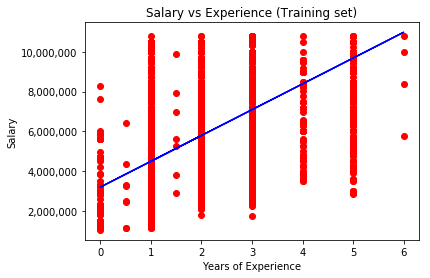

In [20]:
plt.scatter(xTrain, yTrain, color = 'red')
plt.plot(xTrain, predictExpSal.predict(xTrain), color = 'blue')
plt.title('Salary vs Experience (Training set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

formatSal = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(i) for i in formatSal])

plt.show()

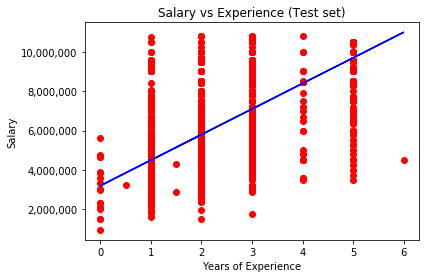

In [21]:
plt.scatter(xTest, yTest, color = 'red')
plt.plot(xTrain, predictExpSal.predict(xTrain), color = 'blue')
plt.title('Salary vs Experience (Test set)')
plt.xlabel('Years of Experience')
plt.ylabel('Salary')

plt.gca().set_yticklabels(['{:,.0f}'.format(i) for i in formatSal])

plt.show()

In [22]:
# Memprediksi gaji berdasarkan experience 
# model.predict(year)
predictExpSal.predict([[10]])

array([[16176781.07268955]])

In [23]:
# Keakuratan model data
predictExpSal.score(xTest, yTest)

0.7196629197502402